In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as dr
from scipy.stats import norm
import statsmodels.api as sm
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
stock = dr.DataReader('ZM','yahoo',start='2020-09-10')['Adj Close'][:60]
stock[:20]

Date
2020-09-10    384.480011
2020-09-11    383.000000
2020-09-14    403.510010
2020-09-15    410.940002
2020-09-16    408.170013
2020-09-17    413.125000
2020-09-18    438.730011
2020-09-21    468.470001
2020-09-22    492.600006
2020-09-23    500.529999
2020-09-24    464.980011
2020-09-25    496.500000
2020-09-28    487.660004
2020-09-29    465.500000
2020-09-30    470.109985
2020-10-01    482.989990
2020-10-02    482.230011
2020-10-05    485.369995
2020-10-06    478.250000
2020-10-07    480.609985
Name: Adj Close, dtype: float64

In [6]:
stock[-1]   # actual price at time T

413.5400085449219

In [40]:
# parameter
S0 = stock[0]   # stock price at start time = 384.48
K = S0*np.exp(stock.pct_change().mean())    # strike price = 385.45
T = 1/6   # expiry time in years
r = stock.pct_change().mean()*60    # annual risk-free interest rate = 0.151
sigma = stock.pct_change().std()*np.sqrt(60)    # volatility = 0.387

In [35]:
# exact solution
I = 100000
ST = 0
for i in range(I):
  ST += S0*np.exp(sigma*np.sqrt(T)*np.random.normal(0,1)+(r-sigma**2/2)*T)
ST = ST/I
ST

394.2355721134254

In [36]:
# Black–Scholes formula
d1 = (np.log(S0/K) + (r+sigma**2/2)*(T-0)) / (sigma*np.sqrt(T-0))
d2 = d1 - sigma*np.sqrt(T-0)

C = S0*norm.cdf(d1) - K*np.exp(-r*(T-0))*norm.cdf(d2)   # call option
P = K*np.exp(-r*(T-0))*norm.cdf(-d2) - S0*norm.cdf(-d1)   # put option

ST = K + C
ST

413.95751606061674

In [30]:
# Euler method
I = 1000   # number of iterations
N = 1000
dt = T/N

ST_E = []
for i in range(I):
  Sn_E = S0
  dB = np.random.normal(0,np.sqrt(dt),N)  # create N random numbers
  for j in dB:
    Sn_E += r*Sn_E*dt + sigma*Sn_E*j
  ST_E.append(Sn_E)

ST_E = sum(ST_E)/I
ST_E

395.3633780291864

In [39]:
# Richardson extrapolation
I = 1000   # number of iterations
N1 = 1000
dt1 = T/N1
ST1, ST2 = [], []

for i in range(I):
  dB = np.random.normal(0,np.sqrt(dt1),N1)  # create N1 random numbers
  
  Sn1 = S0
  for j in dB:
    Sn1 += r*Sn1*dt1 + sigma*Sn1*j
  ST1.append(Sn1)

  Sn2 = S0
  for k in dB[1::2]:    # use same random numbers
    Sn2 += r*Sn2*dt1*2 + sigma*Sn2*k
  ST2.append(Sn2)

ST_R = 2*sum(ST1)/I - sum(ST2)/I
ST_R

392.6918092999584

In [41]:
# Milstein method
I = 1000   # number of iterations
N = 1000
dt = T/N

ST_M = []
for i in range(I):
  Sn_M = S0
  dB = np.random.normal(0,np.sqrt(dt),N)  # create N random numbers
  for j in dB:
    Sn_M += r*Sn_M*dt + sigma*Sn_M*j + 0.5*sigma**2*Sn_M*(j**2-dt)
  ST_M.append(Sn_M)

ST_M = sum(ST_M)/I
ST_M

391.3451171149855

In [42]:
# Convergence error

I = 1000   # number of iterations
ew_E, ew_M, ew_R = [], [], []   # weak error by Euler, Milstein, Richardson extrapolation
es_E, es_M, es_R = [], [], []   # strong error by Euler, Milstein, Richardson extrapolation

for dt in np.logspace(-5,-1,5):   # set a range of delta t: (0.00001, 0.0001, 0.001, 0.01, 0.1)
  tn = np.arange(dt,T+dt,dt)   # create time intervals: (dt, 2dt, ... , T)
  N = len(tn)
  
  Xn_Esum, Xn_Msum, Xn_Rsum, Yn_sum = np.zeros(N), np.zeros(N), np.zeros(int(N/2)), np.zeros(N)
  error_E, error_M, error_R = np.zeros(N), np.zeros(N), np.zeros(int(N/2))

  for i in range(I):
    dB = np.random.normal(0,np.sqrt(dt),N)   # create N random numbers
    
    Yn = S0*np.exp(sigma*dB+(r-sigma**2/2)*tn)   # exact solution

    X_E, Xn_E, X_M, Xn_M = S0, [], S0, []
    for j in dB:
      # Euler method
      X_E += r*X_E*dt + sigma*X_E*j
      Xn_E.append(X_E)
      # Milstein method
      X_M += r*X_M*dt + sigma*X_M*j + 0.5*sigma**2*X_M*(j**2-dt)
      Xn_M.append(X_M)
    
    # Euler method with Richardson extrapolation
    X_E2, Xn_E2 = S0, []
    for k in dB[1::2]:
      X_E2 += r*X_E2*dt*2 + sigma*X_E2*k    
      Xn_E2.append(X_E2)
    Xn_R = 2*np.array(Xn_E[1::2]) - np.array(Xn_E2)

    error_E += abs(Yn-Xn_E)
    error_M += abs(Yn-Xn_M)
    error_R += abs(Yn[1::2]-Xn_R)
    
    Yn_sum += Yn
    Xn_Esum += Xn_E
    Xn_Msum += Xn_M
    Xn_Rsum += Xn_R

  ew_E.append(max(abs(Yn_sum-Xn_Esum)/I))
  ew_M.append(max(abs(Yn_sum-Xn_Msum)/I))
  ew_R.append(max(abs(Yn_sum[1::2]-Xn_Rsum)/I))

  es_E.append(max(error_E/I))
  es_M.append(max(error_M/I))
  es_R.append(max(error_R/I))

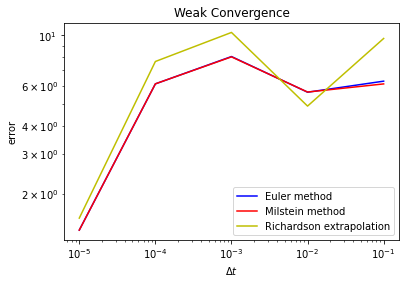

In [43]:
plt.loglog(np.logspace(-5,-1,5), ew_E, label='Euler method', color='b')
plt.loglog(np.logspace(-5,-1,5), ew_M, label='Milstein method', color='r')
plt.loglog(np.logspace(-5,-1,5), ew_R, label='Richardson extrapolation', color='y')
plt.title('Weak Convergence')
plt.xlabel('$\Delta t$')
plt.ylabel('error')
plt.legend()

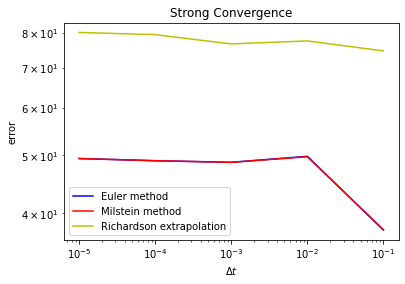

In [44]:
plt.loglog(np.logspace(-5,-1,5), es_E, label='Euler method', color='b')
plt.loglog(np.logspace(-5,-1,5), es_M, label='Milstein method', color='r')
plt.loglog(np.logspace(-5,-1,5), es_R, label='Richardson extrapolation', color='y')
plt.title('Strong Convergence')
plt.xlabel('$\Delta t$')
plt.ylabel('error')
plt.legend()

In [45]:
# Convergence rate
log_dt = sm.add_constant(np.log(np.logspace(-5,-1,5)))
print('weak convergence rate by Euler =', sm.OLS( np.log(ew_E), log_dt).fit().params[1])
print('weak convergence rate by Milstein =', sm.OLS(np.log(ew_M), log_dt).fit().params[1])
print('weak convergence rate by Richardson extrapolation =', sm.OLS(np.log(ew_R), log_dt).fit().params[1])

print('\n'+'strong convergence rate by Euler =', sm.OLS(np.log(es_E), log_dt).fit().params[1])
print('strong convergence rate by Milstein =', sm.OLS(np.log(es_M), log_dt).fit().params[1])
print('strong convergence rate by Richardson extrapolation =', sm.OLS(np.log(es_R), log_dt).fit().params[1])

weak convergence rate by Euler = 0.12757986130867327
weak convergence rate by Milstein = 0.12520897785196416
weak convergence rate by Richardson extrapolation = 0.13864828367746695

strong convergence rate by Euler = -0.023136770064759338
strong convergence rate by Milstein = -0.02309252393479211
strong convergence rate by Richardson extrapolation = -0.007208050701630331
